In [226]:
from l1_csvd.metrics import metric_11, join_sol, Mp, Mah_dist, NR, R_sv
from l1_csvd.utils.seed import seed_everything

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import display
from copy import deepcopy
sns.set()

%matplotlib inline
# %config InlineBackend.figure_format = 'pdf'
%load_ext autoreload
%autoreload 2

seed_everything(42)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import numpy as np
from scipy.stats import ortho_group

from l1_csvd.utils import L1pca

def L1_cSVD(X, K, seed=42, num_iter=10):
    """Get L1 cSVD decomposition.

    Parameters
    ----------
    X:
        data matrix
    K:
        the number of components
    num_iter:
        number of iterations
    """
    
    seed_everything(seed)
    D, N = X.shape
    U = L1pca(X, K)
    A = np.dot(X.T, U)
    Sigma = np.zeros((K, K))
    V = ortho_group.rvs(dim=N, random_state=seed)[:K].T
    #print(V)
    metrics = {
        "Mp": [],
        "metric_11": [],
        "join_sol": [],
        "Mah_dist": [],
        "NR": [],
        "R_sv": []
    }
    
    # metrics["metric_11"].append(metric_11(X, U, Sigma, V))
    # metrics["Mp"].append(Mp(X, U, Sigma, V))
    
    for _ in tqdm(range(num_iter)):
        for i in range(K):
            s = np.empty(N)
            M = np.empty(N)
            for j in range(N):
                s[j] = A[j][i] / V[j][i]

                tmp = A[:, i] - s[j] * V[:, i]
                M[j] = np.linalg.norm(tmp, ord=1)

            j_opt = np.argmin(M)
            Sigma[i][i] = s[j_opt]
        tmp = np.diag(1 / np.diagonal(Sigma))
        U_, Sigma_, V_ = np.linalg.svd(np.dot(A, tmp), full_matrices=False)
        V = np.dot(U_, V_)
        
        metrics["metric_11"].append(metric_11(X, U, Sigma, V))
        metrics["Mp"].append(Mp(X, U, Sigma, V))
                
    return U, Sigma, V, metrics


#### A. Algorithm Analysis: Convergence

In [3]:
X = np.random.randn(10, 50)

In [4]:
all_metrics = []
seeds = np.arange(4)

for s in seeds:
    _, _, _, metrics = L1_cSVD(X, K=4, seed=s, num_iter=6)
    all_metrics.append(metrics)

L1pca start
BNM Iter: 1 | -Loss: 70.10671532863853 | Time spend (min): 5.280176798502604e-05
BNM Iter: 2 | -Loss: 104.37477070705563 | Time spend (min): 5.743900934855143e-05

[[ 2.19943764e-01  4.98919904e-02  1.22030005e-01  2.79396746e-01]
 [-2.75863078e-01  1.35043081e-01 -9.08167410e-02  2.02895276e-02]
 [ 8.25787614e-02  1.07027518e-01 -5.24014277e-02 -2.30935196e-01]
 [-1.90350911e-01 -1.19288784e-01  5.99845370e-02  1.30195166e-01]
 [ 9.04689813e-02 -1.64203619e-02  1.83035100e-02 -7.29910323e-03]
 [ 2.00972099e-01  4.01544453e-02 -8.24511611e-03  5.85642368e-03]
 [-1.09170327e-02  1.57041586e-01 -3.34385094e-01  8.94181916e-02]
 [-1.05158651e-01 -8.25424520e-02 -3.47244001e-01  2.92087285e-02]
 [ 6.93010354e-03 -1.91547470e-01  2.00859646e-01  5.19971830e-02]
 [-7.89675830e-02  2.01550359e-01  8.88378699e-02 -1.68615238e-01]
 [-3.78319386e-02 -8.24324307e-02  1.56522199e-01  2.44790840e-01]
 [-1.37858326e-01 -1.58875268e-01 -2.05700734e-01  2.28256674e-01]
 [ 1.21244924e-01 -9

  0%|          | 0/6 [00:00<?, ?it/s]

L1pca start
BNM Iter: 1 | -Loss: 77.64000181194913 | Time spend (min): 2.6146570841471354e-06
BNM Iter: 2 | -Loss: 82.00409576112014 | Time spend (min): 5.74191411336263e-06
BNM Iter: 5 | -Loss: 87.21785524301079 | Time spend (min): 1.0438760121663411e-05
BNM Iter: 6 | -Loss: 95.2354864992211 | Time spend (min): 1.3244152069091796e-05

[[ 0.23684011 -0.08919806 -0.07701087 -0.15644579]
 [ 0.01343426 -0.05471466  0.06223424  0.20286982]
 [-0.07759797  0.17168924  0.10823559 -0.09503328]
 [ 0.18486525 -0.05001765  0.00348335 -0.10789106]
 [-0.04319766 -0.07283447 -0.00446581  0.02078984]
 [ 0.05400684 -0.14038796 -0.24938545  0.0238221 ]
 [-0.16336668 -0.26465105  0.07607445 -0.1334777 ]
 [-0.05719233 -0.02529956 -0.13805653 -0.10094549]
 [ 0.09744465  0.02767146 -0.23047194  0.0782489 ]
 [ 0.07287173  0.03428796  0.03398704  0.05289074]
 [-0.1675523  -0.23401301 -0.10736557 -0.03360219]
 [ 0.12033587 -0.0101588  -0.17255028  0.04223478]
 [-0.11685788  0.11867729  0.07286063  0.15760559]

  0%|          | 0/6 [00:00<?, ?it/s]

L1pca start
BNM Iter: 1 | -Loss: 83.92085042512693 | Time spend (min): 3.993511199951172e-06
BNM Iter: 2 | -Loss: 89.42002995535275 | Time spend (min): 8.714199066162109e-06

[[-0.05613173 -0.00757839 -0.28771715  0.22092262]
 [ 0.07932857  0.1449554  -0.03339324 -0.07081565]
 [-0.01409748  0.10942454  0.26910129 -0.14012317]
 [-0.13178731  0.09429959  0.06495556  0.07062464]
 [ 0.04158703 -0.00738152 -0.31569718  0.09698488]
 [ 0.03399329 -0.17072978 -0.03318158 -0.06922359]
 [ 0.04448405  0.03638742  0.07379667  0.10825094]
 [ 0.11793875 -0.08791317  0.2476436  -0.17374855]
 [ 0.10647092  0.09716242  0.15038628 -0.17290696]
 [-0.05093533 -0.1290457  -0.02797049  0.08709827]
 [-0.07348865 -0.18787093  0.13809904 -0.11240676]
 [-0.2861646   0.01181562 -0.10993056  0.06919308]
 [-0.16863698  0.14516533 -0.01557551 -0.207773  ]
 [ 0.2026993  -0.22596336 -0.01290362  0.15437351]
 [ 0.00641248  0.11345466 -0.12789192 -0.05678067]
 [ 0.14205718  0.13434916 -0.08344526 -0.25273883]
 [-0.1878

  0%|          | 0/6 [00:00<?, ?it/s]

L1pca start
BNM Iter: 1 | -Loss: 79.18475909013938 | Time spend (min): 3.953774770100911e-06
BNM Iter: 2 | -Loss: 81.08074465307536 | Time spend (min): 7.2677930196126304e-06
BNM Iter: 6 | -Loss: 86.208802152335 | Time spend (min): 1.2775262196858725e-05

[[ 0.24302759  0.05931021  0.01311147 -0.25319967]
 [-0.01019886 -0.13640853 -0.11451322 -0.14658954]
 [ 0.166023   -0.15819527  0.35677744  0.09504282]
 [-0.15949312  0.26666281 -0.02833898  0.08545042]
 [-0.08268504 -0.13636818 -0.00830314  0.00221034]
 [-0.03138913  0.06450123  0.00570599  0.10339758]
 [ 0.09931061 -0.02567097 -0.02641578 -0.04880291]
 [ 0.19323731 -0.11134514  0.03809198  0.01123426]
 [-0.08129419  0.07924671  0.31661594 -0.11022259]
 [-0.12266138  0.01890179  0.23531807 -0.0115284 ]
 [-0.23911537  0.09738014  0.27491766 -0.02944489]
 [-0.06893366 -0.0095073  -0.22804709 -0.04892474]
 [ 0.03701514  0.13860745 -0.07959925 -0.1462719 ]
 [-0.19229757 -0.08761147  0.04629627 -0.10522655]
 [ 0.04533187  0.147408    0.2

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
all_metrics = [{k: v for k, v in x.items() if v} for x in all_metrics]
names = list(all_metrics[0].keys())

res = pd.DataFrame(columns=names + ["seed", "iter"])
for ii, seed in enumerate(seeds):
    for i in range(len(all_metrics[0][names[0]])):
        rr = []
        for name in names:
            rr.append(all_metrics[ii][name][i])
        
        rr.extend([seed, i+1])
        res.loc[len(res) + 1] = rr

for c in res.columns:
    if c not in names:
        res[c] = res[c].astype(int)

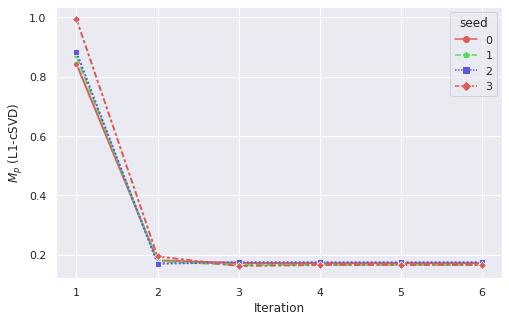

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=res, x="iter", y="Mp", hue="seed", style="seed", markers=["o", "p", "s", "D"], linewidth=2,
             palette="hls", ax=ax)
plt.ylabel(r'$M_p$ (L1-cSVD)')
plt.xlabel(r'Iteration')
plt.savefig("./images/conv.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### B. Performance Analysis with Synthetic Dataset

In [ ]:
D = 
N = 
K_0 = D // 5

U0 = 
S0 = 
V0 = 

X_clean = U0 @ S0 @ V0.T

N = 

R0 = 


#### C. Bayesian Classifier

In [229]:
import pmlb
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [230]:
vowel_data = pmlb.fetch_data('vowel')
vowel_data

,Train or Test,Speaker Number,Sex,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,target
0,1,0,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,8
1,1,0,1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,2
2,1,0,1,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1
3,1,0,1,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,0
4,1,0,1,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0,14,0,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,3
986,0,14,0,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,9
987,0,14,0,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,4
988,0,14,0,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,10


In [231]:
vowel_data.columns

Index(['Train or Test', 'Speaker Number', 'Sex', 'Feature 0', 'Feature 1',
       'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6',
       'Feature 7', 'Feature 8', 'Feature 9', 'target'],
      dtype='object')

### Train test split

In [232]:
target = vowel_data["target"]
vowel_data_dropped = vowel_data.drop(columns=['Train or Test', 'Speaker Number'])
vowel_data_train, vowel_data_test = train_test_split(vowel_data_dropped,
                                                     test_size=1/6, stratify=target)
vowel_data_train.target.value_counts()

2     75
1     75
8     75
10    75
9     75
5     75
4     75
3     75
6     75
0     75
7     75
Name: target, dtype: int64

In [348]:
class BayesianClassifier:
    def __init__(self, use_l1csvd=False):
        self.medians = []
        self.Vs = []
        self.Ss = []
        self.use_l1csvd = use_l1csvd
    
    def make_outliers(self, X_i, power=25, outlier_num=3):
        mean = np.mean(X_i, axis=0)
        indices = np.random.choice(np.arange(X_i.shape[0]), replace=False, size=outlier_num)
        for ind in indices:
            rand_power = 2 * np.random.rand() - 1
            X_i[ind] += rand_power * power * mean
        return X_i
    
    def fit(self, vowel_data, with_outliers=False):
        self.medians = []
        self.Vs = []
        self.Ss = []
        
        for target in range(11):
            X_i = vowel_data[vowel_data_train['target'] == target].drop(columns=['target', 'Sex']).values
            if with_outliers:
                X_i = self.make_outliers(X_i)
            m_i = np.median(X_i, axis=0)
            self.medians.append(m_i)
            if self.use_l1csvd:
                U, S, VT, _ = L1_cSVD(X_i, K=10, seed=42, num_iter=10000)
                S = np.diag(S)
            else:
                U, S, VT = np.linalg.svd(X_i, full_matrices=False)
            self.Vs.append(VT.T)
            self.Ss.append(S)
    
    def predict_one(self, y):
        min_d = np.inf
        ans = None

        for i in range(len(self.medians)):
            d = 0

            m_i = self.medians[i]
            V = self.Vs[i]
            S = self.Ss[i]


            for j in range(m_i.size):
                sqrt_sum = np.sum(V[:, j] * (y - m_i)) / (S[j] / np.sqrt(990))
                d += sqrt_sum * sqrt_sum

            d = np.sqrt(d)
            if d <= min_d:
                min_d = d
                ans = i

        return ans
    
    def predict(self, vowel_data):
        pred = []

        for i, row in vowel_data.drop(columns=['target', 'Sex']).iterrows():
            ans = self.predict_one(row.values)
            pred.append(ans)
        
        return pred

In [347]:
svd_corrupted = []

for _ in tqdm(range(1000), leave=False):
    bclf = BayesianClassifier()
    bclf.fit(vowel_data_train, with_outliers=True)
    pred = bclf.predict(vowel_data_test)
    acc = accuracy_score(vowel_data_test["target"], pred)
    svd_corrupted.append(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [350]:
l1csvd_corrupted = []

for _ in tqdm(range(1000), leave=False):
    bclf = BayesianClassifier(use_l1csvd=True)
    bclf.fit(vowel_data_train, with_outliers=True)
    pred = bclf.predict(vowel_data_test)
    acc = accuracy_score(vowel_data_test["target"], pred)
    l1csvd_corrupted.append(acc)

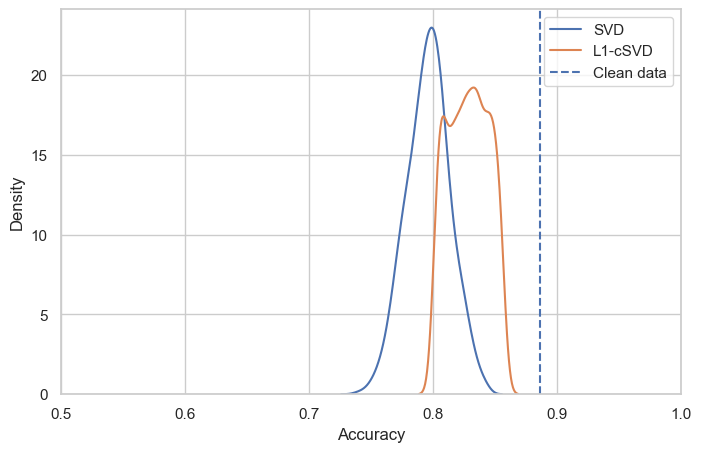

In [352]:
plt.figure(figsize = (8, 5))

bclf = BayesianClassifier()
bclf.fit(vowel_data_train)
pred = bclf.predict(vowel_data_test)
base_acc = accuracy_score(vowel_data_test["target"], pred)

sns.set_style('whitegrid')
sns.kdeplot(np.array(svd_corrupted), label="SVD")
sns.kdeplot(np.array(l1csvd_corrupted), label="L1-cSVD")
plt.axvline(x=base_acc, label="Clean data", linestyle='dashed')
plt.ylabel("Density")
plt.xlabel("Accuracy")
plt.xlim(0.5, 1)
plt.legend()
plt.show()